# Anderson model of localization

## parameter choices

In [1]:
myseed= 111111
width= 50
nimages= 100
img_sizeX= 200
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 32
myepochs= 1
mylr= 0.011
mywd= 1e-6

datanameformat="L{0}-{1}-s{2}"
dataname=datanameformat.format(width,nimages,img_sizeX)
dataname="L50-5000-s100"
#datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
#datapath = '/Users/danlo/ownCloud/' + dataname # Windows home
#homepath = '/Users/danlo/Documents/PX319MLPhases_Data/'

datapath = '/Users/danlo/Documents/PX319MLPhases_Data/' + dataname
homepath = '/Users/danlo/Documents/PX319MLPhases_Data/'
devhomepath = '/Users/danlo/Documents/PX319MLPhases/'

methodformat="Keras-OhtsukiConv2D-{0}"
method=methodformat.format(myseed)
print(dataname,"\n",datapath,"\n",method)

modelname = method+'-model-'+dataname+'.h5'
historyname = method+'-history-'+dataname+'.pkl'

savepath = './'+dataname+'/'
import os
try:
    os.mkdir(savepath)
except FileExistsError:
    pass

modelpath = savepath+modelname
historypath = savepath+historyname

print(datapath,modelpath,historypath,homepath)

L50-5000-s100 
 /Users/danlo/Documents/PX319MLPhases_Data/L50-5000-s100 
 Keras-OhtsukiConv2D-111111
/Users/danlo/Documents/PX319MLPhases_Data/L50-5000-s100 ./L50-5000-s100/Keras-OhtsukiConv2D-111111-model-L50-5000-s100.h5 ./L50-5000-s100/Keras-OhtsukiConv2D-111111-history-L50-5000-s100.pkl /Users/danlo/Documents/PX319MLPhases_Data/


## initializations

In [2]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [4]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.1.0 , keras:  2.3.1
sklearn:  0.23.2


In [5]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [6]:
np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [7]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

## building the CNN

In [8]:
def create_CNN():
    # instantiate model
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(5,5),input_shape=(img_sizeX, img_sizeY, 3),
                     activation = 'relu',  padding='valid'))
    model.add(Conv2D(16, kernel_size=(5,5),activation = 'relu',padding='same'))
    
    model.add(MaxPooling2D(pool_size =(2, 2), padding='same'))

    model.add(Dropout(0.5))
               
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='valid'))  
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', padding='same')) 
                 
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same')) 
    
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(5,5), activation = 'relu',  padding='valid'))
    model.add(Conv2D(64, kernel_size=(5,5),activation = 'relu',padding='same'))
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same'))
                  
    model.add(Dropout(0.5))

    model.add(Flatten())
                             
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax')) 
    
    return model

print('CNN architecture (Ohtsuki) created successfully!')

CNN architecture (Ohtsuki) created successfully!


In [9]:
# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


## learning the images

L20-100-s100 
 /Users/danlo/Documents/PX319MLPhases_Data/L20-100-s100 
 Keras-OhtsukiConv2D-111111
Found 1530 images belonging to 17 classes.
Found 170 images belonging to 17 classes.
Epoch 1/1
6/6 [==============================] - 1s 187ms/step
Accuracy:  0.06470588594675064
loss:  2.844442367553711
Accuracy list:  [0.06470588594675064]


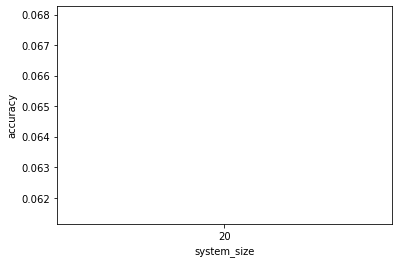

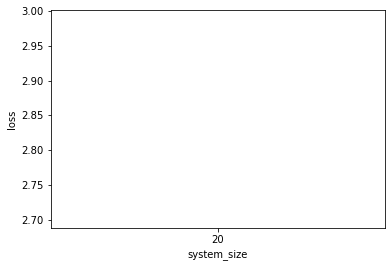

In [10]:
# train DNN and store training info in history
#sys_size_list = [20,30,40,50];
#for (sys_size in sys_size_list):

#myepochs = 1

from keras.preprocessing.image import ImageDataGenerator

sys_scores = []
sys_loss   = []
sys_sizes = ['20']#,'30','40','50']

nsam_res = "-100-s100"

for sys_size in sys_sizes:
    dataname="L" + sys_size + nsam_res
    datapath = '/Users/danlo/Documents/PX319MLPhases_Data/' + dataname
    homepath = '/Users/danlo/Documents/PX319MLPhases_Data/'

    methodformat="Keras-OhtsukiConv2D-{0}"
    method=methodformat.format(myseed)
    print(dataname,"\n",datapath,"\n",method)

    modelname = method+'-model-'+dataname+'.h5'
    historyname = method+'-history-'+dataname+'.pkl'
    
    train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
    test_datagen  = ImageDataGenerator(rescale=1./255)
     
    training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                 shuffle=True,seed=myseed)

    validation_set= train_datagen.flow_from_directory(datapath, 
                                                  subset='validation', 
                                                  target_size = (img_sizeX,img_sizeY),
                                                  batch_size = batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False,seed=myseed)

    num_of_train_samples = training_set.samples
    num_of_test_samples = validation_set.samples
    num_classes = len(validation_set.class_indices)
    
    model = compile_model()
    #print(model.summary())
    
        #Train the CNN
    history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)
    
    score = model.evaluate(validation_set, verbose=1)
    sys_scores.append(score[1])
    sys_loss.append(score[0])
    print("Accuracy: ", score[1])
    print("loss: ", score[0])
    model.save(modelpath) 
        
print("Accuracy list: ", sys_scores)
fig=plt.figure()
plt.plot(sys_sizes, sys_scores)
plt.ylabel('accuracy')
plt.xlabel('system_size')
plt.show()
fig.savefig(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/' + 'sys_size_val_accuracy-' + 'e' + str(myepochs) + '-' + nsam_res + '-' + 'seed_' + str(myseed) + '.png') 

fig=plt.figure()
plt.plot(sys_sizes, sys_loss)
plt.ylabel('loss')
plt.xlabel('system_size')
plt.show()
fig.savefig(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/' + 'sys_size_loss-' + 'e' + str(myepochs) + '-' + nsam_res + '-' + 'seed_' + str(myseed) + '.png') 

In [11]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

## testing the quality of the learned model

Looping the Training, saving inbetween

In [12]:
from tensorflow.keras.models import load_model
for i in range(2):
    model = load_model(modelpath)
    history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = 1,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)
model.save(modelpath) 

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 5 steps
47/47 [==============================] - 15s 323ms/step - loss: 2.8342 - accuracy: 0.0594 - val_loss: 2.8322 - val_accuracy: 0.0625
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 5 steps
47/47 [==============================] - 15s 324ms/step - loss: 2.8332 - accuracy: 0.0601 - val_loss: 2.8329 - val_accuracy: 0.0500


### training history

  ...
    to  
  ['...']
6/6 [==============================] - 1s 92ms/step - loss: 2.8336 - accuracy: 0.0471

Test loss: 2.833550771077474
Test accuracy: 0.047058824


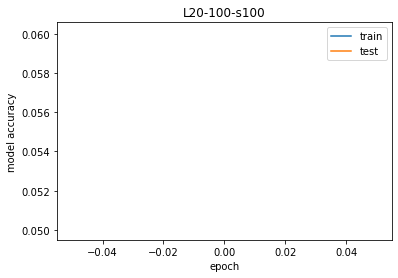

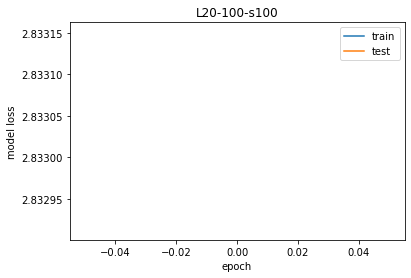

In [13]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+method+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+method+dataname+'_loss'+'.png')
#print(datapath+'/'+surname+dataname+'_loss'+'.png')

### confusion matrix

In [14]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

Instructions for updating:
Please use Model.predict, which supports generators.
6/6 [==============================] - 1s 105ms/step


array([[0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 8, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 8, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 8, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 8, 0, 0, 0, 0,

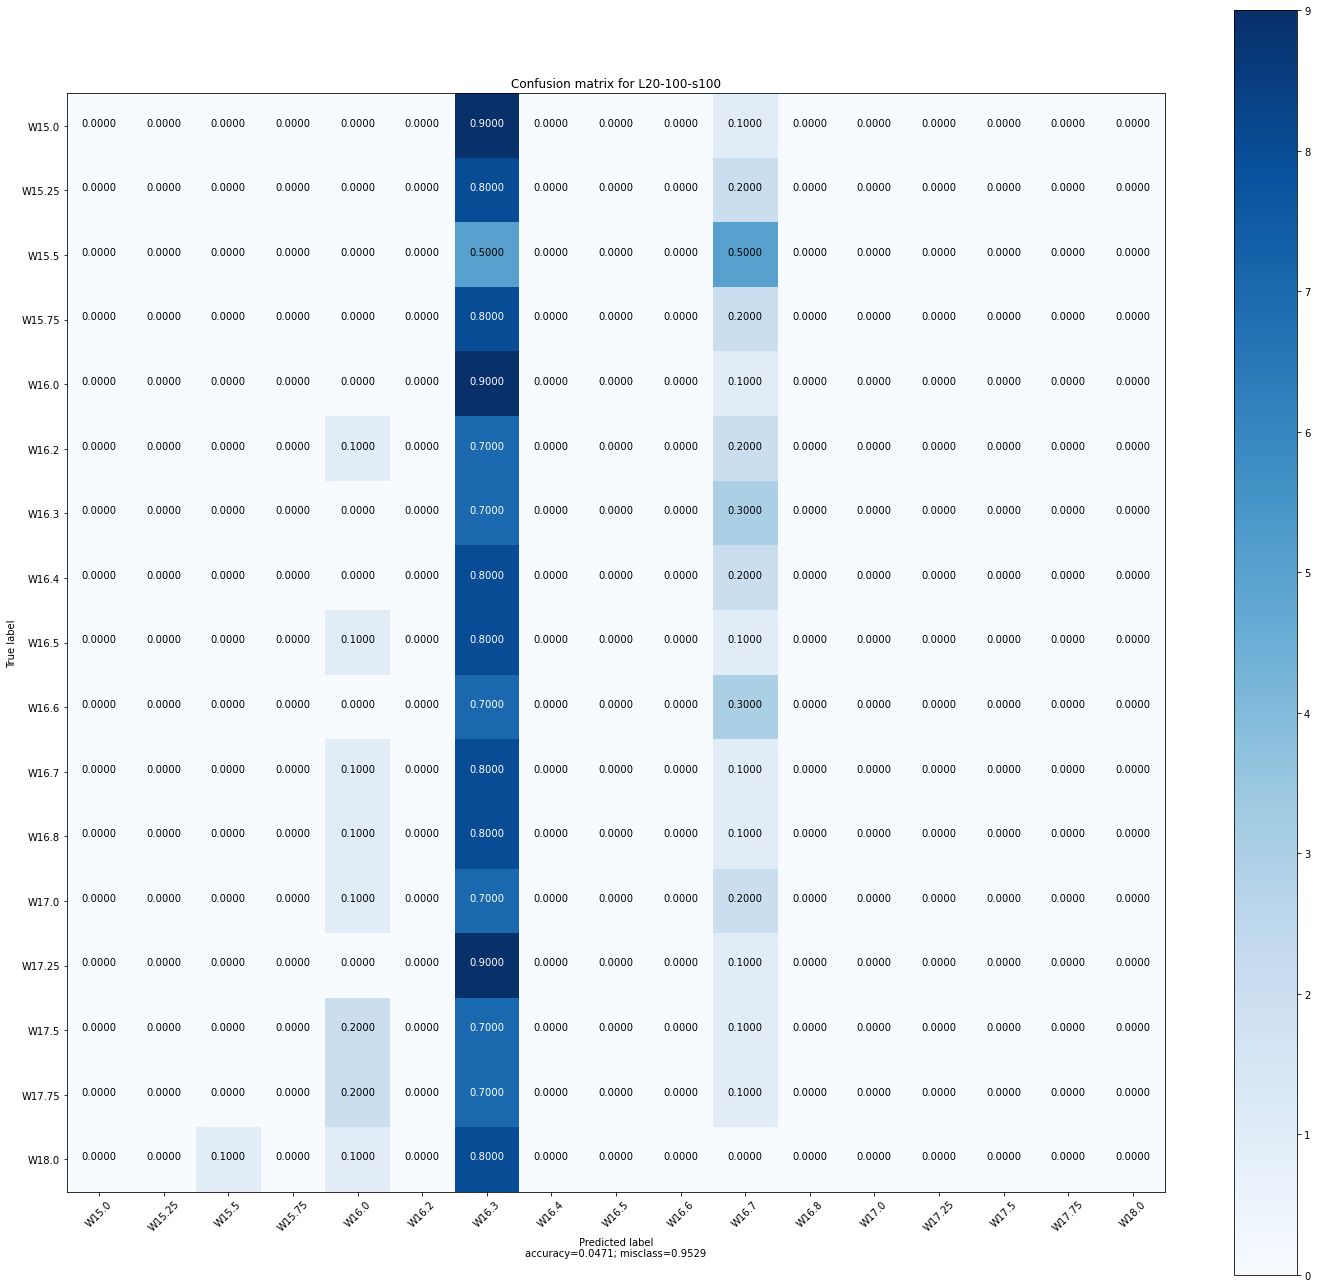

None


In [15]:
os.chdir('../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
os.chdir('../src/')

In [ ]:
%%javascript
IPython.notebook.save_notebook()